# Import

In [28]:
import pandas as pd
import numpy as np
import os
import re
import nltk
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import os

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/50k-celebrity-faces-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 333M/333M [00:02<00:00, 124MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1


In [16]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1/Celebrity_Faces_Dataset"

print(os.listdir(dataset_path)[:10])
print("Total files:", len(os.listdir(dataset_path)))


['017793.jpg', '021605.jpg', '013663.jpg', '025934.jpg', '045791.jpg', '012884.jpg', '035539.jpg', '021201.jpg', '045350.jpg', '008064.jpg']
Total files: 50000


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

# Path to images
dataset_path = "/root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1/Celebrity_Faces_Dataset"

# Hyperparameters
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 3  # RGB

# Transformations (Normalize to [-1,1])
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*CHANNELS, [0.5]*CHANNELS)
])

# Custom Dataset
class CelebDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.png','.jpg','.jpeg'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Load Dataset
dataset = CelebDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Check
print("Dataset size:", len(dataset))
print("Number of batches:", len(dataloader))


Dataset size: 50000
Number of batches: 391


show data sample

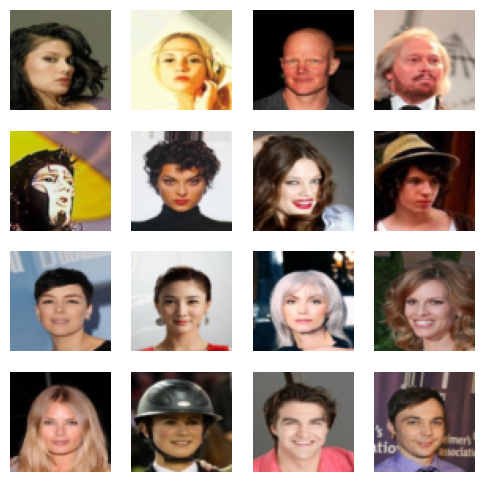

In [20]:

def show_images(batch):
    # batch: Tensor [B, C, H, W]
    grid = batch[:16].clone().detach()
    grid = (grid * 0.5) + 0.5  # unnormalize from [-1,1] to [0,1]
    grid = grid.permute(0, 2, 3, 1).numpy()  # [B, H, W, C] for matplotlib

    fig, axs = plt.subplots(4, 4, figsize=(6,6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(grid[i])
        ax.axis("off")
    plt.show()


batch = next(iter(dataloader))
show_images(batch)


# Data preprocessing


study data

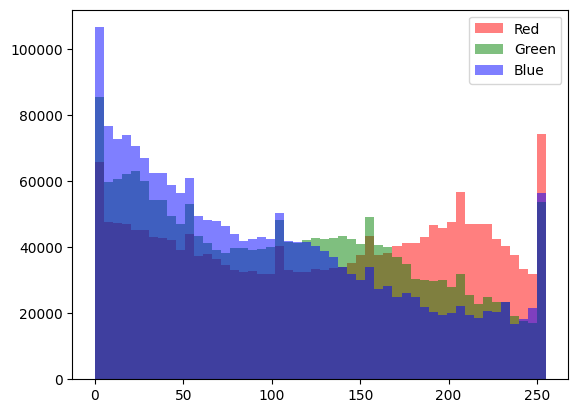

In [23]:

# Use dataset.image_files which contains all image paths
sample_files = random.sample(dataset.image_files, 500)
r_vals, g_vals, b_vals = [], [], []

for f in sample_files:
    img = Image.open(f).convert("RGB").resize((64,64)) # f already contains the full path
    arr = np.array(img)
    r_vals.extend(arr[:,:,0].flatten())
    g_vals.extend(arr[:,:,1].flatten())
    b_vals.extend(arr[:,:,2].flatten())

plt.hist(r_vals, bins=50, alpha=0.5, color='r', label='Red')
plt.hist(g_vals, bins=50, alpha=0.5, color='g', label='Green')
plt.hist(b_vals, bins=50, alpha=0.5, color='b', label='Blue')
plt.legend()
plt.show()


In [24]:
IMAGE_SIZE = 64
CHANNELS = 3  # RGB

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),   # Resize all images
    transforms.ToTensor(),                        # Convert to tensor [0,1]
    transforms.Normalize([0.5]*CHANNELS, [0.5]*CHANNELS)  # Normalize to [-1,1]
])


# ML Models

Generator

In [25]:
import torch
import torch.nn as nn

latent_dim = 100  # size of noise vector
channels = 3      # RGB
ngf = 64          # generator feature maps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, latent_dim, channels, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),       # 4x4 -> 8x8
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),       # 8x8 -> 16x16
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),         # 16x16 -> 32x32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),      # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# instantiate generator
netG = Generator(latent_dim, channels, ngf).to(device)
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator

In [26]:
ndf = 64  # discriminator feature maps

class Discriminator(nn.Module):
    def __init__(self, channels, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),    # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),       # 32x32 -> 16x16
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),     # 16x16 -> 8x8
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),     # 8x8 -> 4x4
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),         # 4x4 -> 1x1
        )

    def forward(self, input):
        out = self.main(input)
        return out.view(-1)

# instantiate discriminator
netD = Discriminator(channels, ndf).to(device)
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


Initialize weights

In [27]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

model train

In [30]:

# Hyperparameters
lr = 0.0002
beta1 = 0.5
epochs = 25
batch_size = 128
latent_dim = 100

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise to see progress
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Labels
real_label = 1.0
fake_label = 0.0

# Output folder
save_dir = "/content/gan_outputs"
os.makedirs(save_dir, exist_ok=True)

iters = 0

for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")
    for i, real_imgs in enumerate(loop):
        b_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        #  Update Discriminator

        netD.zero_grad()
        # Create new label tensors to avoid in-place modification issues
        labels_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_imgs)
        lossD_real = criterion(output, labels_real)

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_imgs = netG(noise)

        # Create a new labels tensor for fake samples
        labels_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        output_fake = netD(fake_imgs.detach()) # Detach fake_imgs here
        lossD_fake = criterion(output_fake, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()


        #  Update Generator

        netG.zero_grad()
        # Create a new labels tensor for the generator's objective
        labels_gen = torch.full((b_size,), real_label, dtype=torch.float, device=device) # generator wants discriminator to think fakes are real
        output = netD(fake_imgs)
        lossG = criterion(output, labels_gen)
        lossG.backward()
        optimizerG.step()

        #  Save progress

        if iters % 100 == 0:
            with torch.no_grad():
                fake_fixed = netG(fixed_noise).detach().cpu()
            save_image((fake_fixed*0.5+0.5), os.path.join(save_dir, f"iter_{iters}.png"), nrow=8)

        if iters % 500 == 0:
            torch.save(netG.state_dict(), os.path.join(save_dir, f"netG_iter_{iters}.pth"))
            torch.save(netD.state_dict(), os.path.join(save_dir, f"netD_iter_{iters}.pth"))

        loop.set_postfix(lossD=lossD.item(), lossG=lossG.item())
        iters += 1

print("Training finished. Samples and checkpoints saved to:", save_dir)


Epoch [25/25]: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s, lossD=0.351, lossG=2.86]

Training finished. Samples and checkpoints saved to: /content/gan_outputs


# model validation

In [31]:

N = 20
noise = torch.randn(N, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake_imgs = netG(noise).cpu()

for i in range(N):
    img = (fake_imgs[i]*0.5 + 0.5)  # unnormalize
    save_image(img, f"{save_dir}/final_{i:03d}.png")

print(f"{N} generated images saved in {save_dir}")


20 generated images saved in /content/gan_outputs


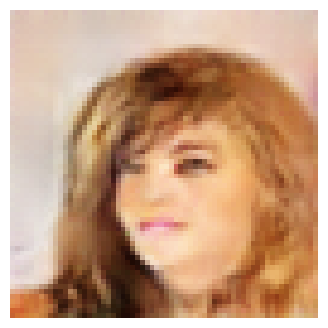

In [33]:
import matplotlib.pyplot as plt
img = fake_imgs[0]
img = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()  # unnormalize و [C,H,W] → [H,W,C]

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.show()


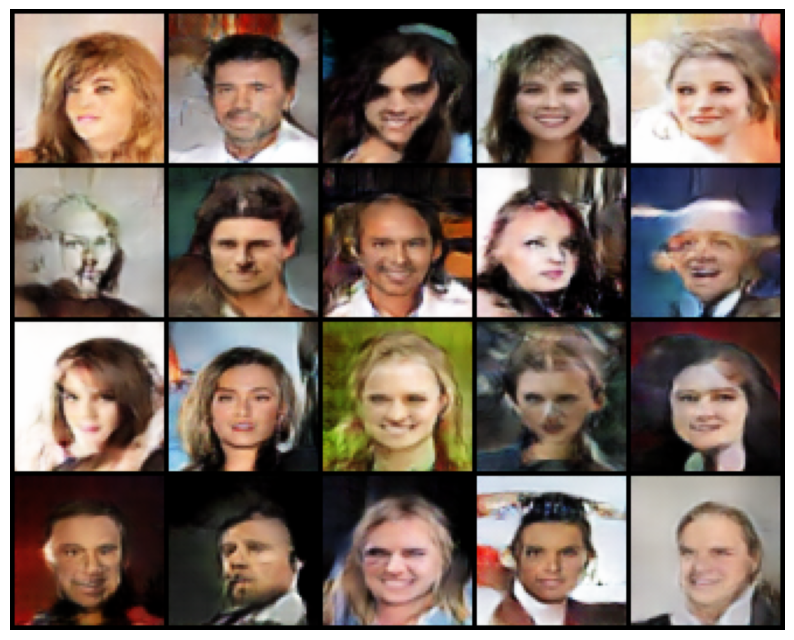

In [34]:
from torchvision.utils import make_grid
grid = make_grid(fake_imgs, nrow=5, normalize=True)  # normalize=True [-1,1] → [0,1]
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1,2,0))  # [C,H,W] → [H,W,C]
plt.axis('off')
plt.show()
